<a href="https://colab.research.google.com/github/vinayprabhu/IOYKT/blob/master/Notebooks/Caption2pic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# This colab notebook was used to generate the basis picture for our podcast 'If only you knew this!'

Most of this notebook is built on the brilliant work by [tacchan7412](https://github.com/tacchan7412).
The reference notebook can be procured from [here](https://github.com/tacchan7412/caption2image/blob/aa476b19364a71ee9fb7916e355f7f09fcd0edad/AttnGAN/eval.ipynb) 



# Common Procedures

In [0]:
# imports
import torch
import torchvision.transforms as transforms
import numpy as np
import os
import sys
import random
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
from PIL import Image
import matplotlib.pyplot as plt

sys.path.append(os.pardir)

In [2]:
# device setup
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [0]:
assert torch.cuda.device_count() == 1

In [4]:
from google.colab import drive
drive.mount('/gdrive')
proj_dir='/gdrive/My Drive/Colab Notebooks/IOYKT/caption2image/AttnGAN/'
os.chdir(proj_dir)

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [5]:
os.listdir()

['Caption2pic.ipynb',
 'DAMSM_main.py',
 'config.py',
 'datasets.py',
 'global_attention.py',
 'losses.py',
 'main.py',
 'models.py',
 'utils.py',
 'results',
 '__pycache__',
 'FreeMono.ttf']

In [6]:
# config
data_dir = '../../data/COCO'
exp_dir = 'results/AttnGAN/COCO/2019_05_14_17_08'
G_epoch = 50
batch_size = 100
test_num = batch_size * 30

# load config from txt
cfg_list_str = ['image_encoder_path', 'text_encoder_path']
cfg_list_int = ['words_num', 't_dim', 'z_dim', 'c_dim', 'ngf', 'branch_num', 'base_size']
cfg_list_float = []
cfg = {}

print('experimental setting')
with open(os.path.join(exp_dir, 'config.txt'), 'r') as f:
    for line in f:
        print(line[:-1])
        split_line = line.split(' ')
        key = split_line[0][:-1]
        if key in cfg_list_str:
            cfg[key] = split_line[1][:-1]
        if key in cfg_list_int:
            cfg[key] = int(split_line[1])
        if key in cfg_list_float:
            cfg[key] = float(split_line[1])

assert len(cfg.keys()) == len(cfg_list_str) + len(cfg_list_int) + len(cfg_list_float)

experimental setting
seed: 7412
data_dir: ../../data/COCO
words_num: 15
image_encoder_path: results/DAMSM/COCO/2019_05_04_00_32/model/image_encoder600.pth
text_encoder_path: results/DAMSM/COCO/2019_05_04_00_32/model/text_encoder600.pth
t_dim: 256
branch_num: 3
base_size: 64
z_dim: 100
c_dim: 100
ndf: 96
ngf: 48
lrD: 0.0002
lrG: 0.0002
epochs: 120
batch_size: 16
snapshot_interval: 5
gamma1: 4.0
gamma2: 5.0
gamma3: 10.0
smooth_lambda: 50.0
date_str: 2019_05_14_17_08


In [7]:
# data preparation
from datasets import TextDataset
from datasets import prepare_data

imsize = 299
image_transform = transforms.Compose([
    transforms.Resize(int(imsize * 76 / 64)),
    transforms.RandomCrop(imsize),
    transforms.RandomHorizontalFlip()])
dataset = TextDataset(data_dir, 'val2014', base_size=imsize, branch_num=1, words_num=cfg['words_num'], transform=image_transform)
# dataset = TextDataset(data_dir, 'train2014', base_size=imsize, branch_num=1, words_num=cfg['words_num'], transform=image_transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, drop_last=True, shuffle=False, num_workers=4)

Load from:  ../../data/COCO/captions.pickle


In [8]:
# model preparation
from models import CNNEncoder
from models import RNNEncoder
from models import AttentionalGNet
    
image_encoder = CNNEncoder(cfg['t_dim'], download=False).to(device)
image_encoder.load_state_dict(torch.load(cfg['image_encoder_path']))
image_encoder.eval()
print('Done with image_encoder')

text_encoder = RNNEncoder(dataset.n_words, cfg['words_num'], nhidden=cfg['t_dim']).to(device)
text_encoder.load_state_dict(torch.load(cfg['text_encoder_path']))
text_encoder.eval()
print('Done with text_encoder')
G = AttentionalGNet(cfg['z_dim'], cfg['t_dim'], cfg['c_dim'], cfg['ngf'], device, cfg['branch_num']).to(device)
G.load_state_dict(torch.load(os.path.join(exp_dir, 'model', 'G_epoch%d.pth' % (G_epoch))))
G.eval()
print('model load complete')

Done with image_encoder
Done with text_encoder
model load complete


# Image Generation

In [0]:
# import utils
from nltk.tokenize import RegexpTokenizer
unloader = transforms.ToPILImage()  # reconvert into PIL image

def show_tensor(tensor):
    image = tensor.add_(1).div_(2).cpu().clone()  # we clone the tensor to not do changes on it
    image = image.squeeze(0)      # remove the fake batch dimension
    image = unloader(image)
    plt.imshow(image)
    
def show_np_arr(arr):
    plt.imshow(arr)
    
def caption_convert(caption):
    cap = caption.replace("\ufffd\ufffd", " ")
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(cap.lower())
    caption_new = []
    for t in tokens:
        t = t.encode('ascii', 'ignore').decode('ascii')
        if len(t) > 0:
            caption_new.append(dataset.wordtoix[t])
    cap_len = len(caption_new)
    assert cap_len <= cfg['words_num']
    return np.asarray(caption_new).astype('int64'), cap_len

# Interactive Image Generation with your Caption

Cop-pasted the Utils.py here for more granular understanding

In [0]:
import os
import errno
import numpy as np

import torch
import torch.nn as nn

from PIL import Image, ImageDraw, ImageFont
from copy import deepcopy
import skimage.transform


# For visualization ################################################
COLOR_DIC = {0:[128,64,128],  1:[244, 35,232],
             2:[70, 70, 70],  3:[102,102,156],
             4:[190,153,153], 5:[153,153,153],
             6:[250,170, 30], 7:[220, 220, 0],
             8:[107,142, 35], 9:[152,251,152],
             10:[70,130,180], 11:[220,20, 60],
             12:[255, 0, 0],  13:[0, 0, 142],
             14:[119,11, 32], 15:[0, 60,100],
             16:[0, 80, 100], 17:[0, 0, 230],
             18:[0,  0, 70],  19:[0, 0,  0]}
FONT_MAX = 50


def drawCaption(convas, captions, ixtoword, vis_size, off1=2, off2=2):
    num = captions.size(0)
    img_txt = Image.fromarray(convas)
    # get a font
    fnt = None  # ImageFont.truetype('Pillow/Tests/fonts/FreeMono.ttf', 50)
    # fnt = ImageFont.truetype('Pillow/Tests/fonts/FreeMono.ttf', 50)
    # fnt = ImageFont.truetype('FreeMono.ttf', 50)
    # fnt=ImageFont.truetype('/usr/share/fonts/truetype/liberation/LiberationSerif-BoldItalic.ttf',50)
    # get a drawing context
    d = ImageDraw.Draw(img_txt)
    sentence_list = []
    for i in range(num):
        cap = captions[i].data.cpu().numpy()
        sentence = []
        for j in range(len(cap)):
            if cap[j] == 0:
                break
            word = ixtoword[cap[j]].encode('ascii', 'ignore').decode('ascii')
            d.text(((j + off1) * (vis_size + off2), i * FONT_MAX), '%d:%s' % (j, word[:6]),
                   font=fnt, fill=(255, 255, 255, 255))
            sentence.append(word)
        sentence_list.append(sentence)
    return img_txt, sentence_list


def build_super_images(real_imgs, captions, ixtoword,
                       attn_maps, att_sze, batch_size, max_word_num,
                       lr_imgs=None, nvis=8):
    real_imgs = real_imgs[:nvis]
    if lr_imgs is not None:
        lr_imgs = lr_imgs[:nvis]
    if att_sze == 17:
        vis_size = att_sze * 16
    else:
        vis_size = real_imgs.size(2)

    text_convas = \
        np.ones([batch_size * FONT_MAX,
                 (max_word_num + 2) * (vis_size + 2), 3],
                dtype=np.uint8)

    for i in range(max_word_num):
        istart = (i + 2) * (vis_size + 2)
        iend = (i + 3) * (vis_size + 2)
        text_convas[:, istart:iend, :] = COLOR_DIC[i]

    real_imgs = \
        nn.Upsample(size=(vis_size, vis_size), mode='bilinear')(real_imgs)
    # [-1, 1] --> [0, 1]
    real_imgs.add_(1).div_(2).mul_(255)
    real_imgs = real_imgs.data.numpy()
    # b x c x h x w --> b x h x w x c
    real_imgs = np.transpose(real_imgs, (0, 2, 3, 1))
    pad_sze = real_imgs.shape
    middle_pad = np.zeros([pad_sze[2], 2, 3])
    post_pad = np.zeros([pad_sze[1], pad_sze[2], 3])
    if lr_imgs is not None:
        lr_imgs = \
            nn.Upsample(size=(vis_size, vis_size), mode='bilinear')(lr_imgs)
        # [-1, 1] --> [0, 1]
        lr_imgs.add_(1).div_(2).mul_(255)
        lr_imgs = lr_imgs.data.numpy()
        # b x c x h x w --> b x h x w x c
        lr_imgs = np.transpose(lr_imgs, (0, 2, 3, 1))

    # batch x seq_len x 17 x 17 --> batch x 1 x 17 x 17
    seq_len = max_word_num
    img_set = []
    num = nvis  # len(attn_maps)

    text_map, sentences = \
        drawCaption(text_convas, captions, ixtoword, vis_size)
    text_map = np.asarray(text_map).astype(np.uint8)

    bUpdate = 1
    for i in range(num):
        attn = attn_maps[i].cpu().view(1, -1, att_sze, att_sze)
        # --> 1 x 1 x 17 x 17
        attn_max = attn.max(dim=1, keepdim=True)
        attn = torch.cat([attn_max[0], attn], 1)
        #
        attn = attn.view(-1, 1, att_sze, att_sze)
        attn = attn.repeat(1, 3, 1, 1).data.numpy()
        # n x c x h x w --> n x h x w x c
        attn = np.transpose(attn, (0, 2, 3, 1))
        num_attn = attn.shape[0]
        print(f'num_attn:{num_attn}')
        #
        img = real_imgs[i]
        if lr_imgs is None:
            lrI = img
        else:
            lrI = lr_imgs[i]
        row = [lrI, middle_pad]
        row_merge = [img, middle_pad]
        row_beforeNorm = []
        minVglobal, maxVglobal = 1, 0
        for j in range(num_attn):
            one_map = attn[j]
            if (vis_size // att_sze) > 1:
                one_map = \
                    skimage.transform.pyramid_expand(one_map, sigma=20,
                                                     upscale=vis_size // att_sze)
            row_beforeNorm.append(one_map)
            minV = one_map.min()
            maxV = one_map.max()
            if minVglobal > minV:
                minVglobal = minV
            if maxVglobal < maxV:
                maxVglobal = maxV
        for j in range(seq_len + 1):
            if j < num_attn:
                one_map = row_beforeNorm[j]
                one_map = (one_map - minVglobal) / (maxVglobal - minVglobal)
                one_map *= 255
                #
                PIL_im = Image.fromarray(np.uint8(img))
                print(img.shape,one_map.shape)
                PIL_att = Image.fromarray(np.uint8(one_map))
                merged = \
                    Image.new('RGBA', (vis_size, vis_size), (0, 0, 0, 0))
                mask = Image.new('L', (vis_size, vis_size), (210))
                merged.paste(PIL_im, (0, 0))
                merged.paste(PIL_att, (0, 0), mask)
                merged = np.array(merged)[:, :, :3]
            else:
                one_map = post_pad
                merged = post_pad
            row.append(one_map)
            row.append(middle_pad)
            #
            row_merge.append(merged)
            row_merge.append(middle_pad)
        row = np.concatenate(row, 1)
        row_merge = np.concatenate(row_merge, 1)
        txt = text_map[i * FONT_MAX: (i + 1) * FONT_MAX]
        if txt.shape[1] != row.shape[1]:
            print('txt', txt.shape, 'row', row.shape)
            bUpdate = 0
            break
        row = np.concatenate([txt, row, row_merge], 0)
        img_set.append(row)
    if bUpdate:
        img_set = np.concatenate(img_set, 0)
        img_set = img_set.astype(np.uint8)
        return img_set, sentences
    else:
        return None


def build_super_images2(real_imgs, captions, cap_lens, ixtoword,
                        attn_maps, att_sze, vis_size=256, topK=5):
    batch_size = real_imgs.size(0)
    max_word_num = np.max(cap_lens)
    text_convas = np.ones([batch_size * FONT_MAX,
                           max_word_num * (vis_size + 2), 3],
                           dtype=np.uint8)

    real_imgs = \
        nn.Upsample(size=(vis_size, vis_size), mode='bilinear')(real_imgs)
    # [-1, 1] --> [0, 1]
    real_imgs.add_(1).div_(2).mul_(255)
    real_imgs = real_imgs.data.numpy()
    # b x c x h x w --> b x h x w x c
    real_imgs = np.transpose(real_imgs, (0, 2, 3, 1))
    pad_sze = real_imgs.shape
    middle_pad = np.zeros([pad_sze[2], 2, 3])

    # batch x seq_len x 17 x 17 --> batch x 1 x 17 x 17
    img_set = []
    num = len(attn_maps)

    text_map, sentences = \
        drawCaption(text_convas, captions, ixtoword, vis_size, off1=0)
    text_map = np.asarray(text_map).astype(np.uint8)

    bUpdate = 1
    for i in range(num):
        attn = attn_maps[i].cpu().view(1, -1, att_sze, att_sze)
        #
        attn = attn.view(-1, 1, att_sze, att_sze)
        attn = attn.repeat(1, 3, 1, 1).data.numpy()
        # n x c x h x w --> n x h x w x c
        attn = np.transpose(attn, (0, 2, 3, 1))
        num_attn = cap_lens[i]
        thresh = 2./float(num_attn)
        #
        img = real_imgs[i]
        row = []
        row_merge = []
        row_txt = []
        row_beforeNorm = []
        conf_score = []
        for j in range(num_attn):
            one_map = attn[j]
            mask0 = one_map > (2. * thresh)
            conf_score.append(np.sum(one_map * mask0))
            mask = one_map > thresh
            one_map = one_map * mask
            if (vis_size // att_sze) > 1:
                one_map = \
                    skimage.transform.pyramid_expand(one_map, sigma=20,
                                                     upscale=vis_size // att_sze)
            minV = one_map.min()
            maxV = one_map.max()
            one_map = (one_map - minV) / (maxV - minV)
            row_beforeNorm.append(one_map)
        sorted_indices = np.argsort(conf_score)[::-1]

        for j in range(num_attn):
            one_map = row_beforeNorm[j]
            one_map *= 255
            #
            PIL_im = Image.fromarray(np.uint8(img))
            PIL_att = Image.fromarray(np.uint8(one_map))
            merged = \
                Image.new('RGBA', (vis_size, vis_size), (0, 0, 0, 0))
            mask = Image.new('L', (vis_size, vis_size), (180))  # (210)
            merged.paste(PIL_im, (0, 0))
            merged.paste(PIL_att, (0, 0), mask)
            merged = np.array(merged)[:, :, :3]

            row.append(np.concatenate([one_map, middle_pad], 1))
            #
            row_merge.append(np.concatenate([merged, middle_pad], 1))
            #
            txt = text_map[i * FONT_MAX:(i + 1) * FONT_MAX,
                           j * (vis_size + 2):(j + 1) * (vis_size + 2), :]
            row_txt.append(txt)
        # reorder
        row_new = []
        row_merge_new = []
        txt_new = []
        for j in range(num_attn):
            idx = sorted_indices[j]
            row_new.append(row[idx])
            row_merge_new.append(row_merge[idx])
            txt_new.append(row_txt[idx])
        row = np.concatenate(row_new[:topK], 1)
        row_merge = np.concatenate(row_merge_new[:topK], 1)
        txt = np.concatenate(txt_new[:topK], 1)
        if txt.shape[1] != row.shape[1]:
            print('Warnings: txt', txt.shape, 'row', row.shape,
                  'row_merge_new', row_merge_new.shape)
            bUpdate = 0
            break
        row = np.concatenate([txt, row_merge], 0)
        img_set.append(row)
    if bUpdate:
        img_set = np.concatenate(img_set, 0)
        img_set = img_set.astype(np.uint8)
        return img_set, sentences
    else:
        return None


####################################################################
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.orthogonal(m.weight.data, 1.0)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)
    elif classname.find('Linear') != -1:
        nn.init.orthogonal(m.weight.data, 1.0)
        if m.bias is not None:
            m.bias.data.fill_(0.0)


def load_params(model, new_param):
    for p, new_p in zip(model.parameters(), new_param):
        p.data.copy_(new_p)


def copy_G_params(model):
    flatten = deepcopy(list(p.data for p in model.parameters()))
    return flatten


def mkdir_p(path):
    try:
        os.makedirs(path)
    except OSError as exc:  # Python >2.5
        if exc.errno == errno.EEXIST and os.path.isdir(path):
            pass
        else:
            raise

given caption: If only you knew this


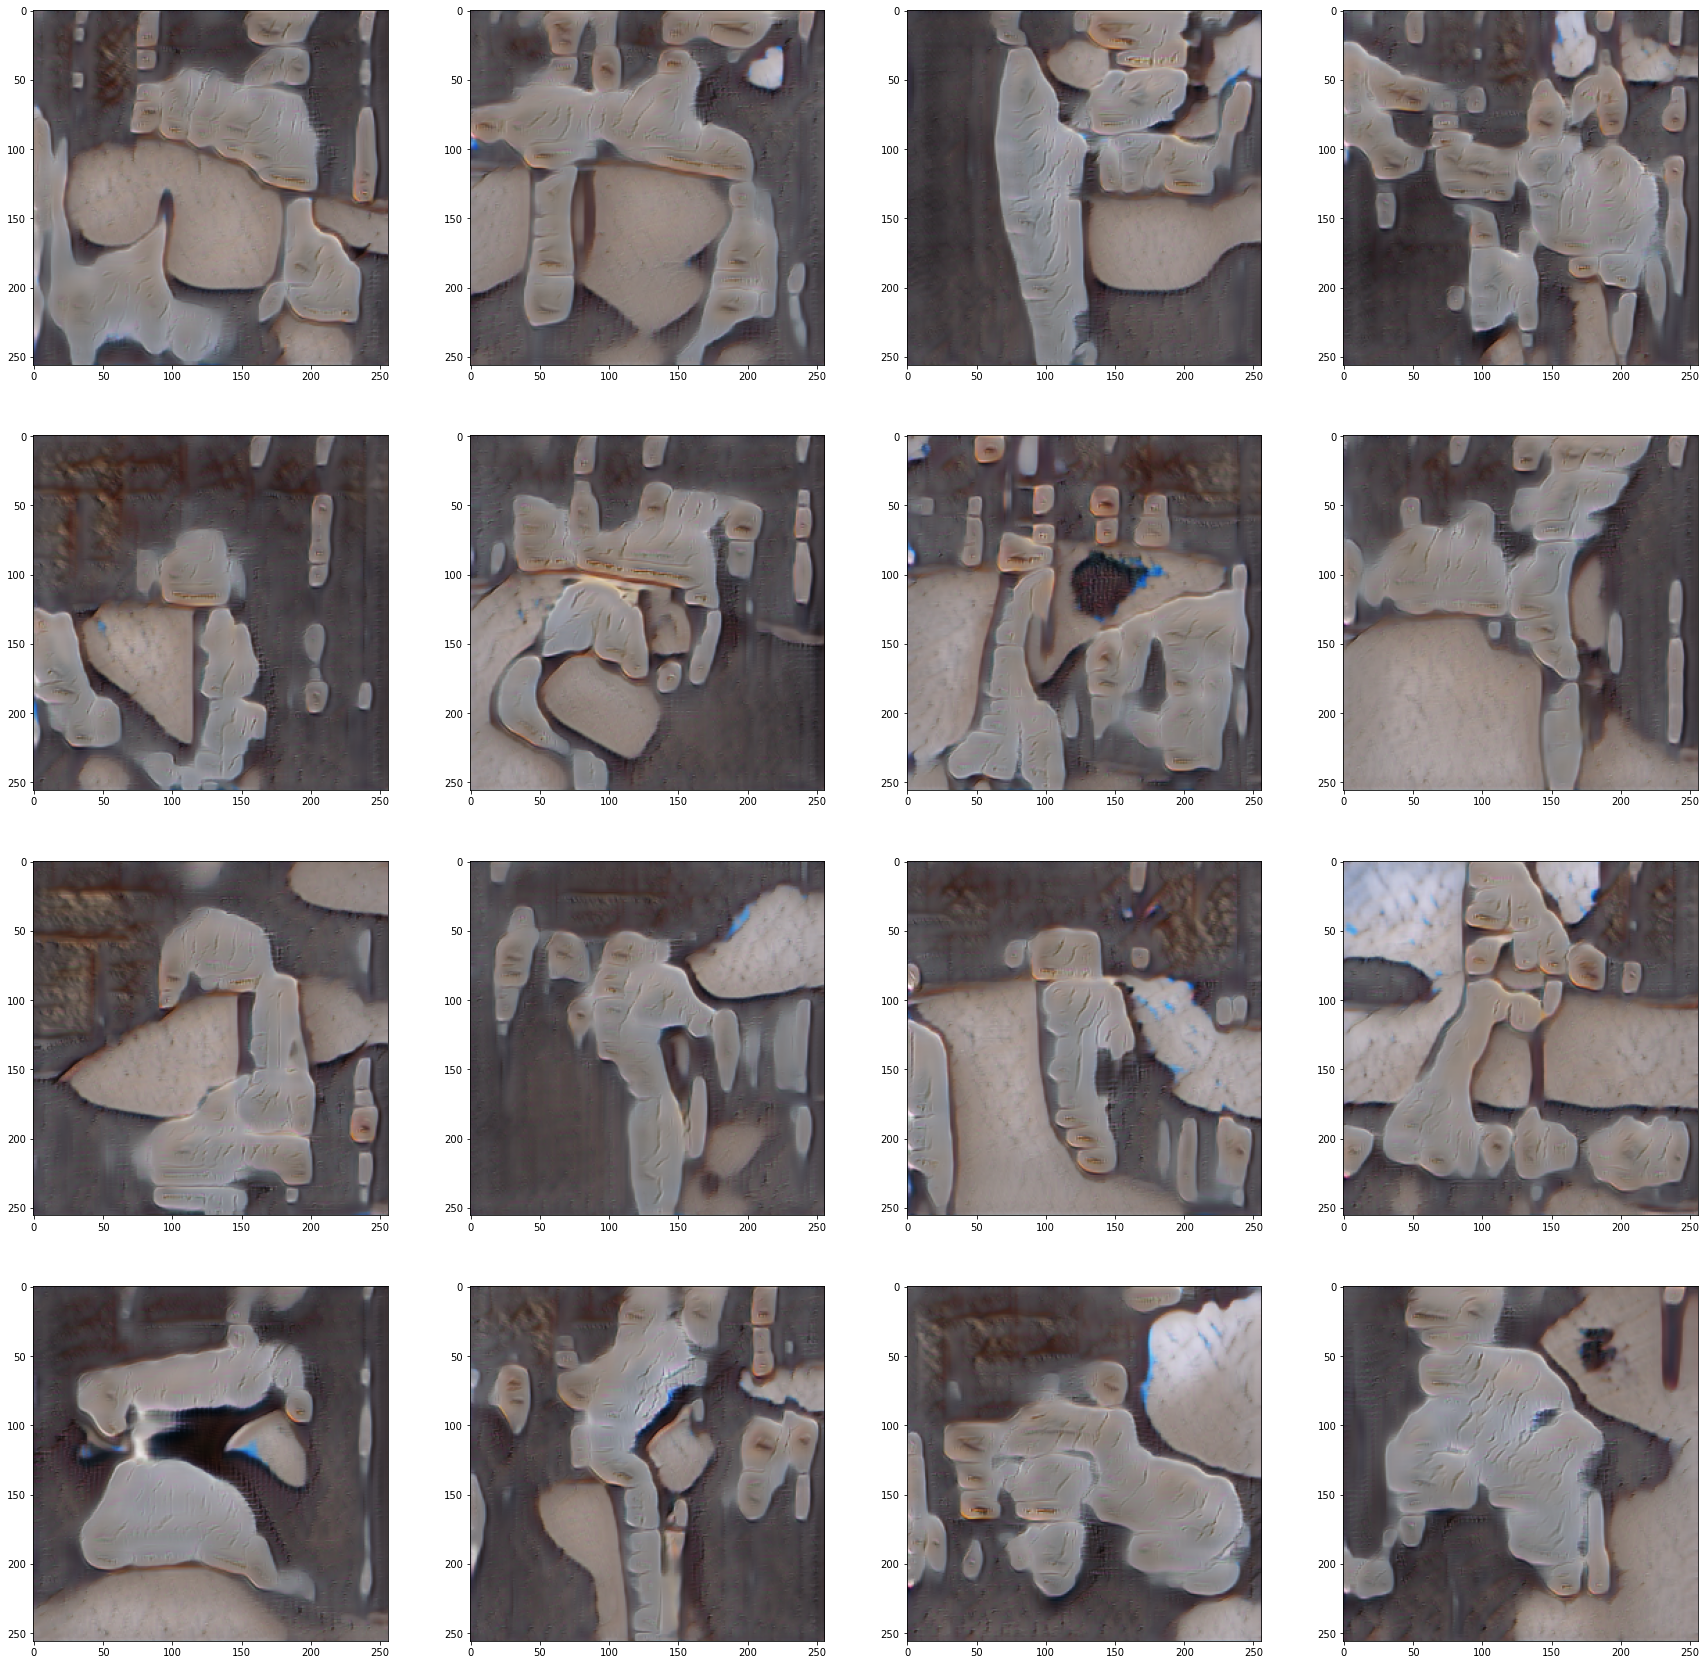

In [12]:
plt.figure(figsize=(30,30))
caption = 'If only you knew this'
print('given caption:', caption)
cap, cap_len = caption_convert(caption)
cap = torch.from_numpy(cap).unsqueeze(0).to(device)
cap_len = torch.tensor(cap_len).unsqueeze(0).to(device)

for trial in range(16):
  ##########################################
  noise = torch.FloatTensor(1, cfg['z_dim']).data.normal_().to(device)
  #######################################################################
  with torch.no_grad():
      words_embs, sent_emb = text_encoder(cap, cap_len)
      words_embs, sent_emb = words_embs.detach(), sent_emb.detach()
      mask = (cap == 0)
      num_words = words_embs.size(2)
      if mask.size(1) > num_words:
          mask = mask[:, :num_words]

      fake_imgs, attention_maps, _, _ = G(noise, sent_emb, words_embs, mask)
      # assert len(attention_maps) >= 1
      # img = fake_imgs[len(attention_maps)].detach().cpu()
      # lr_img = fake_imgs[len(attention_maps) - 1].detach().cpu()
      # attn_maps = attention_maps[-1]
      # att_sze = attn_maps.size(2)
  plt.subplot(4,4,trial+1)
  show_tensor(fake_imgs[-1])
